In [2]:
import glob, h5py, numpy
from pycbc.conversions import mchirp_from_mass1_mass2,chi_eff
from pycbc.sensitivity import volume_montecarlo,volume_to_distance_with_errors
from lal import YRJUL_SI as lal_YRJUL_SI

In [3]:
import numpy as np
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt

# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

# injection values

In [4]:
with h5py.File(
    '/work/yifan.wang/search-high-spin/inj-t10-1p4spin0p9/injhdf/inj_highspin_mass1p4_dist20_300.hdf','r') as f:
    injm1 = f['mass1'][:]
    injm2 = f['mass2'][:]
    injdist = f['distance'][:]
    injspin1z = f['spin1z'][:]
    injspin2z = f['spin2z'][:]
    
injmc = mchirp_from_mass1_mass2(injm1,injm2)
injchieff = chi_eff(injm1,injm2,injspin1z,injspin2z)

In [5]:
injm1

array([1.44146135, 1.43292728, 1.44562092, ..., 1.4468485 , 1.48729092,
       1.42450461])

In [6]:
injm2

array([1.44146135, 1.43292728, 1.44562092, ..., 1.4468485 , 1.48729092,
       1.42450461])

In [7]:
injspin1z

array([ 0.9, -0.9,  0.5, ...,  0.9,  0.9, -0.1])

In [8]:
injspin2z

array([ 0.9, -0.9,  0.5, ...,  0.9,  0.9, -0.1])

In [9]:
injchieff

array([ 0.9, -0.9,  0.5, ...,  0.9,  0.9, -0.1])

# Found and missed array, size = len(injection)

In [10]:
found_bool = numpy.zeros(len(injm1), dtype=bool)
found_ifarlt_bool = numpy.zeros(len(injm1),dtype=bool)
missed_bool = numpy.zeros(len(injm1), dtype=bool)

In [11]:
num_found = 0 
num_missed = 0

In [12]:
fnames = glob.glob(
    '/work/yifan.wang/search-high-spin/inj-t10-1p4spin0p9/runs/*/*/HIGHSPIN_coinc/*HDFINJFIND*.hdf')

In [13]:
fnames

['/work/yifan.wang/search-high-spin/inj-t10-1p4spin0p9/runs/O2/7/HIGHSPIN_coinc/H1L1-HDFINJFIND_HIGHSPIN_INJECTIONS-1171632618-702000.hdf',
 '/work/yifan.wang/search-high-spin/inj-t10-1p4spin0p9/runs/O2/12/HIGHSPIN_coinc/H1L1-HDFINJFIND_HIGHSPIN_INJECTIONS-1175356818-883500.hdf',
 '/work/yifan.wang/search-high-spin/inj-t10-1p4spin0p9/runs/O2/18/HIGHSPIN_coinc/H1L1-HDFINJFIND_HIGHSPIN_INJECTIONS-1184112018-1105200.hdf',
 '/work/yifan.wang/search-high-spin/inj-t10-1p4spin0p9/runs/O2/4/HIGHSPIN_coinc/H1L1-HDFINJFIND_HIGHSPIN_INJECTIONS-1169107218-1066800.hdf',
 '/work/yifan.wang/search-high-spin/inj-t10-1p4spin0p9/runs/O2/11/HIGHSPIN_coinc/H1L1-HDFINJFIND_HIGHSPIN_INJECTIONS-1174649000-707818.hdf',
 '/work/yifan.wang/search-high-spin/inj-t10-1p4spin0p9/runs/O2/16/HIGHSPIN_coinc/H1L1-HDFINJFIND_HIGHSPIN_INJECTIONS-1181845818-979200.hdf',
 '/work/yifan.wang/search-high-spin/inj-t10-1p4spin0p9/runs/O2/9/HIGHSPIN_coinc/H1L1-HDFINJFIND_HIGHSPIN_INJECTIONS-1173188118-714300.hdf',
 '/work/yifan.

In [14]:
len(fnames)

48

In [15]:
loundest_ifar = 1.01 #a constant
t = 0 #foreground time

for fname in fnames:
    f = h5py.File(fname, 'r')
    num_found += len(f['found/ifar_exc'])
    num_missed += len(f['missed/after_vetoes'])#after_vetoes: I think it means some injections are actually 
    #injected to veto times 'by accident', what one really cares about should be those 'within_analysis'
    #There is also an argument named 'within_analysis', which is identical to that of 'after_vetoes'
    
    ifar = f['found/ifar_exc'][:]
    #turn the found and missed indices to True
    injindex = f['found/injection_index'][:]
    injindex_ifarlt = injindex[numpy.where(ifar>=loundest_ifar)[0]]
    
    found_bool[injindex] = True
    found_ifarlt_bool[injindex_ifarlt] = True
    
    missindex = f['missed/after_vetoes'][:] # is this also indices??? Yes it is
    missed_bool[missindex] = True
    
    t += f.attrs['foreground_time_exc'] / lal_YRJUL_SI

In [16]:
found_bool.sum()

105806

In [17]:
found_ifarlt_bool.sum()

44993

In [18]:
num_found

105806

In [19]:
missed_bool.sum()

87807

In [20]:
num_missed

87807

# VT

In [21]:
np.unique(injchieff)

array([-0.9, -0.9, -0.9, -0.5, -0.1, -0.1,  0.1,  0.1,  0.5,  0.9,  0.9,
        0.9])

In [22]:
spin = numpy.array([-0.9,-0.5,-0.1,0.1,0.5,0.9])

In [23]:
spin

array([-0.9, -0.5, -0.1,  0.1,  0.5,  0.9])

In [24]:
found_bool ^ found_ifarlt_bool

array([False, False, False, ..., False, False, False])

In [25]:
found_bool & (~found_ifarlt_bool)

array([False, False, False, ..., False, False, False])

In [26]:
np.all(found_bool ^ found_ifarlt_bool == found_bool & (~found_ifarlt_bool))

True

In [27]:
injchieff

array([ 0.9, -0.9,  0.5, ...,  0.9,  0.9, -0.1])

In [28]:
unique_chieff = np.unique(injchieff)

In [29]:
unique_chieff

array([-0.9, -0.9, -0.9, -0.5, -0.1, -0.1,  0.1,  0.1,  0.5,  0.9,  0.9,
        0.9])

In [30]:
realmissed_bool = (found_bool ^ found_ifarlt_bool) | missed_bool

In [31]:
realmissed_bool

array([False, False, False, ..., False, False, False])

In [32]:
realmissed_bool.sum()

148620

In [33]:
found_bool.sum() - found_ifarlt_bool.sum() + missed_bool.sum()

148620

In [34]:
spin

array([-0.9, -0.5, -0.1,  0.1,  0.5,  0.9])

In [35]:
volume = {}
num_total = 0
num_found = 0
num_missed = 0

for spinv in spin:
    region = np.isclose(injchieff,spinv) 
        
    found_dist = injdist[found_ifarlt_bool & region]
    missed_dist = injdist[realmissed_bool & region]
        
    found_mc = injmc[found_ifarlt_bool & region]
    missed_mc = injmc[realmissed_bool & region]
        
    num_total += region.sum()
    num_found += len(found_dist)
        
    if len(found_dist) == 0:
        print('no injections are found with chieff: ', spinv)
        v=0
        e=0
    else:
        print('found %d injections!!' % len(found_dist))
        v, e = volume_montecarlo(found_dist, missed_dist, 
                                 found_mc, missed_mc, 
                                 'distance', 'uniform', 'distance',20,500)
        volume[spinv] = [v,e]

found 7685 injections!!
found 7551 injections!!
found 7497 injections!!
found 7452 injections!!
found 7467 injections!!
found 7341 injections!!


In [36]:
volume

{-0.9: [30913765.372275606, 578668.9837696837],
 -0.5: [30141245.7179196, 569690.8891347998],
 -0.1: [29812342.813222963, 574893.1710286533],
 0.1: [29459288.669986226, 561410.4297856073],
 0.5: [30229105.35661051, 573805.5551018069],
 0.9: [28675431.93669151, 545746.3006195974]}

In [37]:
num_total

1445649

In [38]:
len(injm1)

1445649

In [39]:
num_found

44993

In [40]:
found_ifarlt_bool.sum()

44993

In [41]:
t

0.61381508733237

# Rate

In [42]:
volume

{-0.9: [30913765.372275606, 578668.9837696837],
 -0.5: [30141245.7179196, 569690.8891347998],
 -0.1: [29812342.813222963, 574893.1710286533],
 0.1: [29459288.669986226, 561410.4297856073],
 0.5: [30229105.35661051, 573805.5551018069],
 0.9: [28675431.93669151, 545746.3006195974]}

In [43]:
chieffv = []
rate = []
rate_high = []
rate_low = []

for spinv in volume:
    chieffv.append(spinv)
    rate.append(2.3/t/volume[spinv][0])
    rate_high.append(2.3/t/(volume[spinv][0]-volume[spinv][1]))
    rate_low.append(2.3/t/(volume[spinv][0]+volume[spinv][1]))

In [44]:
chieffv = np.array(chieffv)
rate = np.array(rate)*1e9
rate_high = np.array(rate_high)*1e9
rate_low = np.array(rate_low)*1e9

In [45]:
rate-rate_low

array([2.22721603, 2.3060849 , 2.37788103, 2.3786344 , 2.30907464,
       2.44046951])

In [46]:
rate_high-rate

array([2.31218829, 2.39493755, 2.47139312, 2.47105573, 2.39843201,
       2.535165  ])

In [53]:
error = np.vstack(((rate-rate_low),(rate_high-rate)))

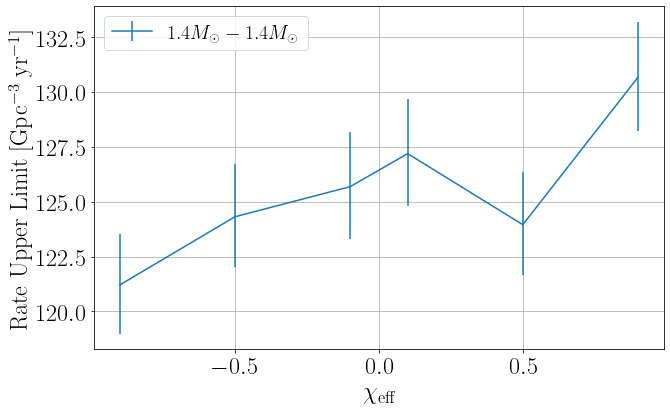

In [54]:
#error = np.array(rate_low, rate_high).T
plt.errorbar(chieffv,rate,yerr=error,fmt='-',label='$1.4M_\odot - 1.4M_\odot$')
plt.xlabel('$\chi_\mathrm{eff}$')
plt.ylabel('Rate Upper Limit [Gpc$^{-3}$ yr$^{-1}$]')
plt.legend(loc='upper left')

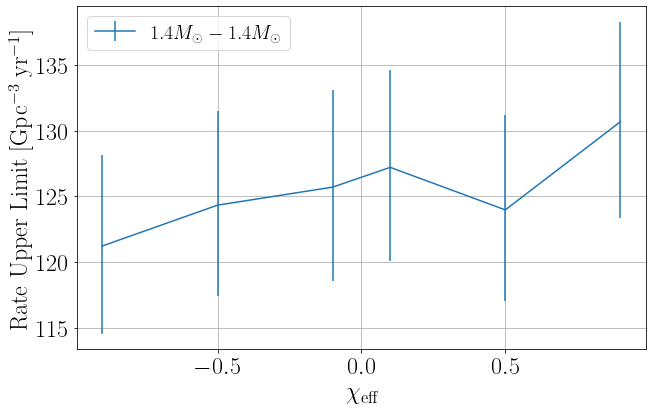

In [55]:
error = np.vstack((3*(rate-rate_low),3*(rate_high-rate)))
plt.errorbar(chieffv,rate,yerr=error,fmt='-',label='$1.4M_\odot - 1.4M_\odot$')
plt.xlabel('$\chi_\mathrm{eff}$')
plt.ylabel('Rate Upper Limit [Gpc$^{-3}$ yr$^{-1}$]')
plt.legend(loc='upper left')

In [50]:
volume

{-0.9: [30913765.372275606, 578668.9837696837],
 -0.5: [30141245.7179196, 569690.8891347998],
 -0.1: [29812342.813222963, 574893.1710286533],
 0.1: [29459288.669986226, 561410.4297856073],
 0.5: [30229105.35661051, 573805.5551018069],
 0.9: [28675431.93669151, 545746.3006195974]}

# Distance

In [51]:
chieffv = []
dist = []
dist_high = []
dist_low = []

for spinv in volume:
    chieffv.append(spinv)
    d,dhigh,dlow = volume_to_distance_with_errors(volume[spinv][0], volume[spinv][1])
    dist.append(d)
    dist_high.append(dhigh)
    dist_low.append(dlow)

In [52]:
dist,dist_high,dist_low

([194.69483588062926,
  193.05936025159573,
  192.3545656859935,
  191.5922255517889,
  193.24676315783867,
  189.87762301449732],
 [1.2073165904381256,
  1.2087359076825805,
  1.2285741944045299,
  1.2094175526245294,
  1.2150736002614053,
  1.197011698871762],
 [1.2224785343040878,
  1.2240641363775069,
  1.2444718064446363,
  1.2248822075765702,
  1.230548811540956,
  1.2122972536768373])